In [1]:
from commons import data_processing
import numpy as np 
import pandas as pd
import altair as alt
import re
import ntpath
from scipy import ndimage
from commons import my_mzml
from commons import generate_hex
from scipy import signal

## This notebook is used to extract data from .mzxml, plot peaks, and determine peak shapes.

In [2]:
# gather mzxml files
bcap_xmls = data_processing.get_files(r'F:\Research\MS Data\Lumos\20220503\mzXML Files')
files = [x for x in bcap_xmls if re.search('1x', x)]

std_xmls = data_processing.get_files(r'F:\Research\MS Data\Lumos\20210825\mzXML')
files = files + [x for x in std_xmls if re.search('_1_', x)]

# create parser lookup taple to store mzxml files
parsers = {}
for file in files:
    print(file)
    base, ext = ntpath.splitext(ntpath.basename(file))
    spl = base.split('_')
    desc = '_'.join(spl[-3:])
    parsers[desc] = my_mzml.mzXML(file)

F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_30C_1x_run1.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_30C_1x_run2.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_30C_1x_run3.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_45C_1x_run1.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_45C_1x_run2.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_45C_1x_run3.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_60C_1x_run1.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_60C_1x_run2.mzXML
F:\Research\MS Data\Lumos\20220503\mzXML Files\20220427_GD_EnrGly_PGC_60C_1x_run3.mzXML
F:\Research\MS Data\Lumos\20210825\mzXML\20210710_GlycEnr_1_30C_Run1.mzXML
F:\Research\MS Data\Lumos\20210825\mzXML\20210710_GlycEnr_1_30C_Run2.mzXML
F:\Research\MS Data\Lumos\20210825\mzXML\20210710_GlycEnr_

In [73]:
# read in the data prepared by 'glycopeptide_analysis.ipynb'

extract_data = pd.read_csv('./Working_Datafiles/for_eic_extract.csv')

# extracted needed data to assess progress
temps = extract_data.temperature.unique()
_gps = extract_data.pep_mods.unique()

# create new dataframe to store data
extracted_data = pd.DataFrame()

# for each glycopeptide, get small dataframe (gp only)
i = 1
for gpep, frame in data_processing.iterate_contents('pep_mods', extract_data, get_item=True):
    
    print(f'Processing {i}/{len(_gps)}', end='\r')
    # store every 50 glycopeptides because the dataframe is getting too big
    if i % 50 == 0:
        extracted_data.to_csv(f'./objects/extracted_data/eic_{i-50}-{i}.csv', index=False)
        extracted_data = pd.DataFrame()
    i+=1

    
    # determine lowest error mass
    frame.loc[:, 'abs_error'] = frame.delta_m_ppm.map(
        lambda x: abs(x)
    )
    lowest_err = frame.abs_error.min().item()
    
    # get m/z value belonging to lowest ppm error
    try:
        search_mass = frame[frame.abs_error==lowest_err].mz_da.drop_duplicates().item()
    except:
        # if here, multiple m/z values had lowest error
        search_mass = frame[frame.abs_error==lowest_err]['mz_da'].tolist()[0]

    # determine which experiment
    exp = frame['sample'].unique().item()
    
    # grab correct parsers
    if exp == 'BCaP_MT10':
        used_parsers = [k for k in parsers.keys() if re.search('1x', k)]
    else:
        used_parsers = [k for k in parsers.keys() if re.search('1_', k)]

    # for each temperature
    for temp in temps:
        # compile scan time
        if temp not in frame.temperature.unique():
            avg_time = None 
        else:
            f = frame[frame.temperature==temp]
            avg_time = round(f.rt_min.mean(), 2)

        # grab parser objects needed
        temp_parsers = [k for k in used_parsers if re.search(temp, k)]
    
        # extract data
        for p in temp_parsers:
            data = parsers[p]
            x, y = data.ms1_extract(search_mass, tolerance=5)
            
            # apply light smoothing to reduce noise
            y = ndimage.gaussian_filter(y, 2)

            # cast data into dataframe
            run_data = pd.DataFrame({
                'glycopeptide':[gpep]*len(x),
                'time':x,
                'abundance':y,
                'temperature':[temp] * len(x),
                'rt':[avg_time] * len(x),
                'glycan_type':frame.glycan_type.unique().tolist() * len(x),
                'run': [p.lower()] * len(x)
            })

            # append this data and move on
            extracted_data = extracted_data.append(run_data)
            extracted_data.reset_index(drop=True, inplace=True)


extracted_data.to_csv(f'./objects/extracted_data/eic_650-{i}.csv', index=False)

In [2]:
# read in the data we extracted
eic_data = data_processing.get_files(r'./objects/extracted_data')
eic = pd.DataFrame()
for file in eic_data:
    print(file)
    eic = pd.concat([eic, pd.read_csv(file)])
    eic.reset_index(drop=True, inplace=True)


./objects/extracted_data\eic_0-50.csv
./objects/extracted_data\eic_100-150.csv
./objects/extracted_data\eic_150-200.csv
./objects/extracted_data\eic_200-250.csv
./objects/extracted_data\eic_250-300.csv
./objects/extracted_data\eic_300-350.csv
./objects/extracted_data\eic_350-400.csv
./objects/extracted_data\eic_400-450.csv
./objects/extracted_data\eic_450-500.csv
./objects/extracted_data\eic_50-100.csv
./objects/extracted_data\eic_500-550.csv
./objects/extracted_data\eic_550-600.csv
./objects/extracted_data\eic_600-650.csv
./objects/extracted_data\eic_650-658.csv


In [3]:
# data is out of order, correct it
eic = eic.sort_values(['glycopeptide', 'run', 'time'])
eic.reset_index(drop=True, inplace=True)

# cast some needed information to columns
eic.loc[:, 'run'] = eic.run.map(lambda x: x.split('_')[-1])
eic.loc[:, 'identified'] = eic.rt.notnull()

In [4]:
# we want to find a reasonable time window for each eic, create a funciton
def find_time_range(frame):
    '''
    Compares min and max retention times associated with peptide, returns
    time window.
    
    :arg frame: (pd.DataFrame)  dataframe containing information
    '''
    d = frame[['temperature', 'rt']].drop_duplicates().dropna()
    d = d.to_dict('list')
    d = dict(zip(d['temperature'], d['rt']))

    keys = list(d.keys())

    if len(keys) == 3 or keys == ['30C', '60C']:
        low, high = round(d['30C']-6), round(d['60C']+6)
    elif len(keys) == 2:
        if keys == ['30C', '45C']:
            low, high = round(d['30C']-6), round(d['45C']+9)
        elif keys == ['45C', '60C']:
            low, high = round(d['45C']-9), round(d['45C']+9)
    elif keys == ['30C']:
        low, high = round(d['30C']-6), round(d['30C']+9)
    elif keys == ['45C']:
        low, high = round(d['45C']-9), round(d['45C']+6)
    elif keys == ['60C']:
        low, high = round(d['60C']-9), round(d['60C']+6)

    return frame[(frame.time >= low) & (frame.time<=high)]

#### Create an extracted image for each glycopeptide

In [67]:
# create unique color scale
my_colors = alt.Color(
    "temperature:N",
    scale=alt.Scale(
        domain=["30C", "45C", "60C"],
        range=["#6E6581", "#B0B2BB", "#6B8A97"]
    ),
)

top = eic.groupby(['glycan_type', 'glycopeptide']).head(7)
i = 0
for gp, frame in data_processing.iterate_contents('glycopeptide', eic[eic.glycopeptide.isin(top.glycopeptide)], get_item=True):

    # get the concise time window
    f = find_time_range(frame)

    title = f.glycopeptide.unique()[0]
    
    # create altair object
    base = alt.Chart(f).encode(
        x='time:Q',
        y='abundance:Q',
        color=my_colors,
    )

    # plot lines and fill area
    line = base.mark_line()
    area = base.mark_area(opacity=0.5)

    # save image
    (area + line).facet(
        row='run:N',
        column='temperature:N'
    ).properties(title=title).save(f'./objects/images/{title}.png')
    i += 1

{'30C': 14.41, '45C': 15.75, '60C': 16.35} ['30C', '45C', '60C']
gets 8 22
{'30C': 13.71, '45C': 15.53, '60C': 16.16} ['30C', '45C', '60C']
gets 8 22
{'45C': 14.42, '60C': 15.09} ['45C', '60C']
{'30C': 6.11} ['30C']
{'30C': 9.03, '45C': 8.94, '60C': 8.7} ['30C', '45C', '60C']
gets 3 15
{'30C': 9.5, '45C': 9.8, '60C': 9.09} ['30C', '45C', '60C']
gets 4 15
{'30C': 9.64, '45C': 10.19, '60C': 9.16} ['30C', '45C', '60C']
gets 4 15
{'30C': 9.1, '45C': 8.92, '60C': 8.66} ['30C', '45C', '60C']
gets 3 15
{'30C': 18.98, '45C': 19.55, '60C': 22.87} ['30C', '45C', '60C']
gets 13 29
{'30C': 16.43, '45C': 19.62, '60C': 18.99} ['30C', '45C', '60C']
gets 10 25
{'30C': 18.0, '45C': 19.56, '60C': 20.2} ['30C', '45C', '60C']
gets 12 26
{'30C': 20.77, '45C': 19.82} ['30C', '45C']
{'30C': 17.56, '45C': 18.87, '60C': 20.38} ['30C', '45C', '60C']
gets 12 26
{'30C': 17.48, '45C': 19.56, '60C': 21.23} ['30C', '45C', '60C']
gets 11 27
{'30C': 21.34, '45C': 21.9, '60C': 20.78} ['30C', '45C', '60C']
gets 15 27
{'

#### Following extraction, data was manually evaluated for instances where bad peak picking occurred. Those were removed from consideration.

In [5]:
import os 

# get names of kept objects
hand_picked = [f for f in os.listdir('./objects/images')]
hand_names = []
for file in hand_picked:
    base, _ = ntpath.splitext(ntpath.basename(file))
    hand_names.append(base)

In [18]:
# for each valid glycopeptide, scrape peak height, width, and area

made = 0
kept_data = pd.DataFrame()
for gp, frame in data_processing.iterate_contents('glycopeptide', eic, get_item=True):
    i = 0

    if gp not in hand_names:
        continue
    print(made, end='\r')
    
    f = find_time_range(frame)
    for temp_val, temp in data_processing.iterate_contents('temperature', f, get_item=True):
        
        for run_val, run in data_processing.iterate_contents('run', temp, get_item=True):
            try:
                # get x and y data
                data = run[['time', 'abundance']].to_numpy()
                x, y = data[:, 0], data[:, 1]

                # find highest coordinated
                max_y = np.max(y)
                max_x = x[np.where(y==max_y)][0]

                # find all relevant peaks > 10% of maximum
                peak, prom = signal.find_peaks(y, height=0.1*max_y, width=5)
                peak_times = x[peak]

                # keep only those peaks <3 minutes away from major peak
                valid_peaks = peak[np.where(np.logical_and(peak_times>=max_x-3, peak_times<=max_x+3))]

                # get major peak
                major_peak, major_prom = signal.find_peaks(y, height=max_y)

                # find width
                major_width = signal.peak_widths(y, major_peak, 0.9)

                # find left and right bounds
                major_left, major_right = int(major_width[2]), int(major_width[3])
                
                # calculate area
                area = np.trapz(y[major_left:major_right])

                # save data
                run.loc[:, 'resolvabe_peaks'] = len(valid_peaks)
                run.loc[:, 'major_peak_width'] = major_width[0][0]
                run.loc[:, 'major_peak_area'] = np.log2(area)
                run.loc[:, 'major_peak_height'] = np.log2(max_y)

                kept_data = pd.concat([kept_data, run])
                kept_data.reset_index(drop=True, inplace=True)
            except:
                print(gp, temp_val, run_val)
                continue
    made += 1

CVYNCSFIK_HexNAc(4)Hex(5)NeuAc(1) 60C run3
DKNGTRAEPPLNASASDQGEK_HexNAc(1)Fuc(1) 60C run3
KLCPDCPLLAPLNDSR_HexNAc(3)Hex(4) 30C run1
LCPDCPLLAPLNDSR_HexNAc(4)Hex(4) 60C run3
LCPDCPLLAPLNDSR_HexNAc(4)Hex(5)NeuAc(2) 45C run2
LCPDCPLLAPLNDSR_HexNAc(5)Hex(5)Fuc(1) 30C run2
LCPDCPLLAPLNDSR_HexNAc(5)Hex(5)Fuc(1) 30C run3
LIDNNK_HexNAc(2)Hex(2)Fuc(1) 30C run1
LVALAVIDEKNTSVEHTR_HexNAc(2)Hex(8) 30C run1
MAAALNATGR_HexNAc(2)Hex(6) 30C run1
NPEYNK_HexNAc(5)Hex(6)NeuAc(2) 45C run1
SRNLTK_HexNAc(2)Hex(6) 60C run1
SRNLTK_HexNAc(2)Hex(6) 60C run2
SRNLTK_HexNAc(2)Hex(6) 60C run3
TVNVSVPK_HexNAc(2)Hex(4) 45C run3
TVNVSVPK_HexNAc(2)Hex(4) 60C run1
TVNVSVPK_HexNAc(2)Hex(4) 60C run2
VQPFNVTQGK_HexNAc(3)Hex(4) 30C run1


#### create boxplots of height, width, area

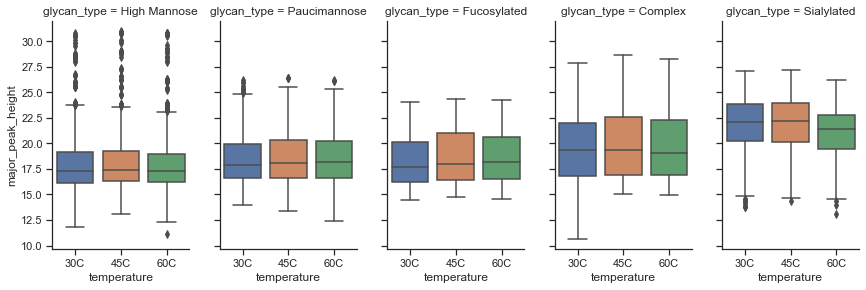

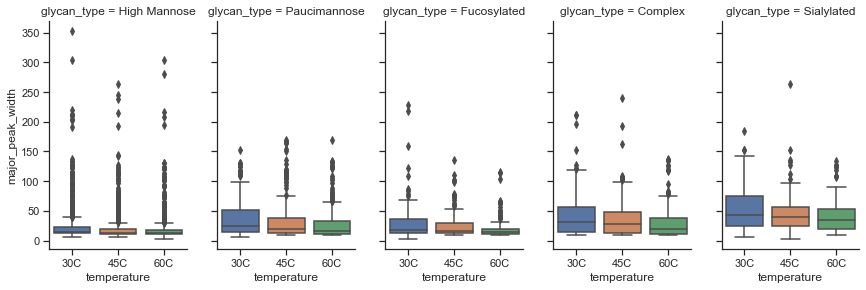

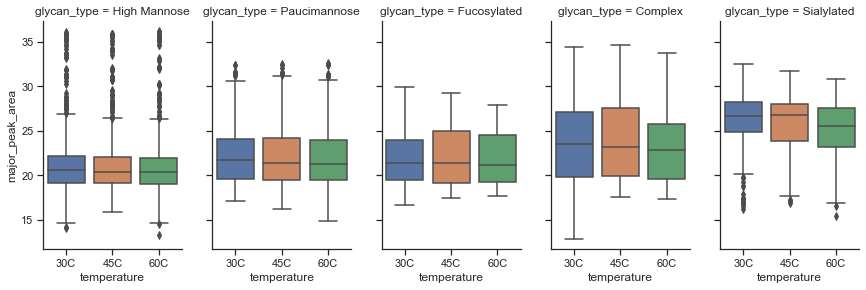

In [230]:
# define color scale
colors = generate_hex.generate_colors(['#6E6581', '#B0B2BB', '#6B8A97'], 3)


height = alt.Chart(kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run'])).mark_boxplot(size=45).encode(
    x='temperature:N',
    y='gp_height:Q',
    # row='identified:N',
    column='glycan_type:N',
    color=alt.Color('temperature:N', scale=alt.Scale(range=colors))
).transform_aggregate(
    gp_height='mean(major_peak_height)',
    groupby=['glycopeptide', 'temperature', 'identified', 'glycan_type']
).properties(width=150, height=100)

width = alt.Chart(kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run'])).mark_boxplot(size=45).encode(
    x='temperature:N',
    y='gp_width:Q',
    # row='identified:N',
    column='glycan_type:N',
    color=alt.Color('temperature:N', scale=alt.Scale(range=colors))
).transform_aggregate(
    gp_width='mean(major_peak_width)',
    groupby=['glycopeptide', 'temperature', 'identified', 'glycan_type']
).properties(width=150, height=100)

area = alt.Chart(kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run'])).mark_boxplot(size=45).encode(
    x='temperature:N',
    y='gp_area:Q',
    # row='identified:N',
    column='glycan_type:N',
    color=alt.Color('temperature:N', scale=alt.Scale(range=colors))
).transform_aggregate(
    gp_area='mean(major_peak_area)',
    groupby=['glycopeptide', 'temperature', 'identified', 'glycan_type']
).properties(width=150, height=100)

peaks = alt.Chart(kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run'])).mark_boxplot(size=45).encode(
    x='temperature:N',
    y='res_peaks:Q',
    # row='identified:N',
    column='glycan_type:N',
    color=alt.Color('temperature:N', scale=alt.Scale(range=colors))
).transform_aggregate(
    res_peaks='mean(resolvabe_peaks)',
    groupby=['glycopeptide', 'temperature', 'identified', 'glycan_type']
).properties(width=150, height=100)

(height | width | area).save('./figures/PeakTrends.svg')
(height | width | area)



# i don't like altair's boxplots. Use seaborn instead
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.catplot(x='temperature', y='major_peak_height', col='glycan_type', kind='box', data=kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run']), height=4, aspect=0.6)
plt.savefig('./figures/MajorPeakHeight.svg')
sns.catplot(x='temperature', y='major_peak_width', col='glycan_type', kind='box', data=kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run']), height=4, aspect=0.6)
plt.savefig('./figures/MajorPeakWidth.svg')
sns.catplot(x='temperature', y='major_peak_area', col='glycan_type', kind='box', data=kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run']), height=4, aspect=0.6)
plt.savefig('./figures/MajorPeakArea.svg')

In [183]:
# transform data into new dataframe to treat each row as unique occurrence

# remove duplicated
k = kept_data.drop_duplicates(['glycopeptide', 'temperature', 'run'])

all_peptides = pd.DataFrame()
for gp, frame in data_processing.iterate_contents('glycopeptide', k, get_item=True):
    this_peptide = pd.DataFrame()
    for temp, t_frame in data_processing.iterate_contents('temperature', frame, get_item=True):
        t_frame = t_frame.T

        # extract data
        found = t_frame.loc['identified'].any()
        wanted = t_frame.loc[['major_peak_area', 'major_peak_height', 'major_peak_width']]
        temps = t_frame.loc['temperature', :].tolist()
        
        # create new column names
        runs = t_frame.loc['run', :].tolist()
        zips = [[z[0], z[1]] for z in zip(temps, runs)]
        cols = ['_'.join(z) for z in zips]
        wanted.columns=cols 

        
        wanted.loc[:, f'identied_{temp}'] = found
        wanted = wanted.reset_index()
        wanted = wanted.rename(columns={'index':'kind'})
        this_peptide = pd.concat([this_peptide, wanted.iloc[:, 1:]], axis=1)
    # fill in remaining information
    this_peptide.loc[:, 'glycan_type'] = t_frame.loc['glycan_type', :].unique()[0]
    this_peptide.loc[:, 'glycopeptide'] = gp
    this_peptide.loc[:, 'kind'] = ['major_peak_area', 'major_peak_height', 'major_peak_width']
    try:
    # this_peptide.reset_index(inplace=True, drop=True)
        all_peptides = all_peptides.append(this_peptide)
        all_peptides.reset_index(drop=True, inplace=True)
    except:
        display(this_peptide)
        print(temp)
    # all_peptides

In [184]:
# calculate mean intensities for all temperatures

thirties = [c for c in all_peptides.columns if re.search('30C_run', c)]
all_peptides.loc[:, '30C_mean'] = all_peptides[thirties].mean(axis=1)

forties = [c for c in all_peptides.columns if re.search('45C_run', c)]
all_peptides.loc[:, '45C_mean'] = all_peptides[forties].mean(axis=1)

sixties = [c for c in all_peptides.columns if re.search('60C_run', c)]
all_peptides.loc[:, '60C_mean'] = all_peptides[sixties].mean(axis=1)

all_peptides.loc[:, '30C_diff'] = all_peptides['30C_mean'] - all_peptides['30C_mean']
all_peptides.loc[:, '45C_diff'] = all_peptides['45C_mean'] - all_peptides['30C_mean']
all_peptides.loc[:, '60C_diff'] = all_peptides['60C_mean'] - all_peptides['30C_mean']

all_peptides

,30C_run1,30C_run2,30C_run3,identied_30C,45C_run1,45C_run2,45C_run3,identied_45C,60C_run1,60C_run2,...,identied_60C,glycan_type,glycopeptide,kind,30C_mean,45C_mean,60C_mean,30C_diff,45C_diff,60C_diff
0,20.841309,20.775831,20.772332,True,21.101022,20.928953,21.076829,True,21.28416,21.271879,...,True,High Mannose,AAIPSALDTNSSK_HexNAc(2)Hex(6),major_peak_area,20.796491,21.035601,21.354857,0.0,0.239110,0.558366
1,17.854344,17.791869,17.836908,True,18.123645,17.901593,18.070761,True,17.798732,17.812438,...,True,High Mannose,AAIPSALDTNSSK_HexNAc(2)Hex(6),major_peak_height,17.827707,18.032000,17.882450,0.0,0.204293,0.054743
2,15.021746,14.529077,14.568625,True,14.403497,14.714,14.432246,True,20.443721,20.85483,...,True,High Mannose,AAIPSALDTNSSK_HexNAc(2)Hex(6),major_peak_width,14.706483,14.516581,20.861365,0.0,-0.189901,6.154883
3,22.290205,23.397587,22.001705,True,20.988615,19.12945,19.05523,True,19.091472,19.297723,...,True,High Mannose,AAIPSALDTNSSK_HexNAc(2)Hex(8),major_peak_area,22.563166,19.724432,19.418599,0.0,-2.838734,-3.144567
4,19.354277,20.698163,19.197498,True,17.72099,16.628183,16.546184,True,16.370377,16.611951,...,True,High Mannose,AAIPSALDTNSSK_HexNAc(2)Hex(8),major_peak_height,19.749979,16.965119,16.713331,0.0,-2.784860,-3.036648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,23.503784,23.758084,23.857434,False,23.711285,23.716018,23.655141,True,23.33178,23.55236,...,False,Paucimannose,YSHDFNFHINYGDLGFLGPEDLRVFGSQNLTTVK_HexNAc(2)He...,major_peak_height,23.706434,23.694148,23.587262,0.0,-0.012286,-0.119172
1667,18.915653,16.406379,15.483405,False,14.319795,13.2879,13.433592,True,14.93168,13.162289,...,False,Paucimannose,YSHDFNFHINYGDLGFLGPEDLRVFGSQNLTTVK_HexNAc(2)He...,major_peak_width,16.935146,13.680429,13.761586,0.0,-3.254717,-3.173560
1668,26.86304,26.886734,26.888905,False,26.708998,26.602733,26.627334,True,26.433628,26.562779,...,False,Fucosylated,YSHDFNFHINYGDLGFLGPEDLRVFGSQNLTTVK_HexNAc(3)He...,major_peak_area,26.879560,26.646355,26.633844,0.0,-0.233205,-0.245715
1669,23.674261,23.941387,24.058136,False,23.928416,23.88696,23.969261,True,23.663743,23.882213,...,False,Fucosylated,YSHDFNFHINYGDLGFLGPEDLRVFGSQNLTTVK_HexNAc(3)He...,major_peak_height,23.891261,23.928212,23.918345,0.0,0.036951,0.027083


In [211]:
# keep and plot differences
differences = all_peptides[['glycopeptide', 'glycan_type', 'kind', 'identied_45C', '30C_diff', '45C_diff', '60C_diff']]

# map the initial direction from 30C
def map_direction(row):
    val = row['45C_diff']
    if val >0:
        return 'up'
    else:
        return 'down'

differences.loc[:, 'initial_direction'] = differences.apply(map_direction, axis=1)
differences = differences.melt(['glycopeptide', 'glycan_type', 'kind', 'identied_45C', 'initial_direction'])


glycan_color_scale = alt.Scale(
    domain=[
        'Sialylated',
        'Fucosylated',
        'Complex',
        'Paucimannose',
        'High Mannose',
    ],
    range=[
        '#6E6581',
        '#AF3A53',
        '#6B8A97',
        '#B0B2BB',
        '#658A64',
    ]
)

chart = alt.Chart(differences).mark_line(opacity=0.25).encode(
    x=alt.X('variable:N', title=''),
    y=alt.Y('value:Q'),
    detail='glycopeptide:N',
    column='glycan_type:N',
    color=alt.Color('glycan_type:N', scale=glycan_color_scale)
).transform_filter(alt.datum.kind=='major_peak_height').properties(width=150)


chart.save('./figures/GlycopeptideHeightByGlycan.svg')
chart

c:\Users\Graham Delafield\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


alt.Chart(...)

#### Extract example HM glycopeptides for representeation

In [4]:
hm = eic[eic.glycopeptide=='AEPPLNASASDQGEK_HexNAc(2)Hex(7)']
hm = hm[(hm.time>=15)&(hm.time<=25)]

hm.loc[:, 'run'] = hm.run.map(lambda x: x[-4:])

my_colors = alt.Color(
    "temperature:N",
    scale=alt.Scale(
        domain=["30C", "45C", "60C"],
        range=["#6E6581", "#B0B2BB", "#6B8A97"]
    ),
)


base = alt.Chart(hm).encode(
        x=alt.X('time:Q', title='Retention Time (min)'),
        y=alt.Y('abundance:Q', title='Relative Abundance', 
            axis=alt.Axis(
                format='.1e'
        )),
        color=my_colors,
    )
line = base.mark_line().properties(width=200, height=100)
area = base.mark_area(opacity=0.5)

high_mannose = (area + line).facet(
    row='run:N',
    column='temperature:N'
).properties(
    title='AEPPLNASASDQGEK_HexNAc(2)Hex(7)'
).configure_title(anchor='middle')

# high_mannose.save('./figures/HighMannoseExtract.svg')

In [5]:
sial = eic[eic.glycopeptide=='LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)NeuAc(1)']
sial = sial[(sial.time>=45)&(sial.time<=60)]

sial.loc[:, 'run'] = sial.run.map(lambda x: x[-4:])


base = alt.Chart(sial).encode(
        x=alt.X('time:Q', title='Retention Time (min)'),
        y=alt.Y('abundance:Q', title='Relative Abundance', 
            axis=alt.Axis(
                format='.1e'
        )),
        color=my_colors,
    )
line = base.mark_line().properties(width=200, height=100)
area = base.mark_area(opacity=0.5)

sialylated = (area + line).facet(
    row='run:N',
    column='temperature:N'
).properties(
    title='LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)NeuAc(1)'
).configure_title(anchor='middle')

# sialylated.save('./figures/SialylatedExtract.svg')

In [13]:
pauc = eic[eic.glycopeptide=='NGTRAEPPLNASASDQGEK_HexNAc(2)Hex(1)']
pauc = pauc[(pauc.time>=20)&(pauc.time<=34)]
pauc.loc[:, 'run'] = pauc.run.map(lambda x: x[-4:])


base = alt.Chart(pauc).encode(
        x=alt.X('time:Q', title='Retention Time (min)',
            axis=alt.Axis(
                labelFlush=False
            )),
        y=alt.Y('abundance:Q', title='Relative Abundance', 
            axis=alt.Axis(
                format='.1e'
        )),
        color=my_colors,
    )
line = base.mark_line().properties(width=200, height=100)
area = base.mark_area(opacity=0.5)

paucimannose = (area + line).facet(
    row='run:N',
    column='temperature:N'
).properties(
    title='NGTRAEPPLNASASDQGEK_HexNAc(2)Hex(1)'
).configure_title(anchor='middle')

paucimannose.save('./figures/PaucimannoseExtract.svg')

In [14]:
fuc = eic[eic.glycopeptide=='VASVININPNTTHSTGSCR_HexNAc(4)Hex(5)Fuc(1)']
fuc = fuc[(fuc.time>=24) & (fuc.time<=34)]
fuc.loc[:, 'run'] = fuc.run.map(lambda x: x[-4:])


base = alt.Chart(fuc).encode(
        x=alt.X('time:Q', title='Retention Time (min)',
            axis=alt.Axis(
                labelFlush=False
            )),
        y=alt.Y('abundance:Q', title='Relative Abundance', 
            axis=alt.Axis(
                format='.1e'
        )),
        color=my_colors,
    )
line = base.mark_line().properties(width=200, height=100)
area = base.mark_area(opacity=0.5)

fucosylated = (area + line).facet(
    row='run:N',
    column='temperature:N'
).properties(
    title='VASVININPNTTHSTGSCR_HexNAc(4)Hex(5)Fuc(1)'
).configure_title(anchor='middle')

fucosylated.save('./figures/FucosylatedExtract.svg')
